# Import Dependencies :

Thisimports essential libraries required for image processing, data manipulation, visualization, model development, and performance evaluation. It sets up the foundational tools for the entire workflow, including deep learning frameworks and image utilities.

In [1]:
import os, cv2, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Flatten, Dense, Dropout, GlobalAveragePooling2D,
                                     BatchNormalization, Input)
from tensorflow.keras.optimizers import Adam


# Dataset Download and Dataset:

This section checks whether the rice image dataset is already available locally. If not, it downloads and extracts the dataset from a specified Kaggle source. The aim is to ensure the required data is available for training and evaluation.

In [2]:
import os

if not os.path.exists("/content/rice_dataset/Rice_Image_Dataset"):
    print("Downloading dataset...")
    !wget -q https://www.muratkoklu.com/datasets/Rice_Image_Dataset.zip
    !unzip -q Rice_Image_Dataset.zip -d rice_dataset
    print("Dataset downloaded and extracted.")
else:
    print("Dataset already exists. Skipping download.")


Dataset downloaded and extracted.


#Defining Constants and Set Seeds:

We set the random seed for reproducibility and defines constants such as image size, batch size, number of epochs, and the data path. It ensures that the experiments are consistent and parameterized.

In [3]:
# Constants
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
data_path = "/content/rice_dataset/Rice_Image_Dataset"
MAX_IMAGES=1000


# Image Loading and Preprocessing
This part involves traversing the dataset directories, reading images using OpenCV, resizing them, and mapping them to appropriate labels for classification.

In [4]:
label_map_modified = {
    name: idx for idx, name in enumerate(sorted(os.listdir(data_path)))
    if os.path.isdir(os.path.join(data_path, name))
}

file_paths, labels = [], []
for label_name, label_idx in label_map_modified.items():
    folder = os.path.join(data_path, label_name)
    for img_file in os.listdir(folder):
        file_paths.append(os.path.join(folder, img_file))
        labels.append(label_idx)

sample_indices = random.sample(range(len(file_paths)), MAX_IMAGES)

X, y = [], []
for i in tqdm(sample_indices, desc="Loading images"):
    img = cv2.imread(file_paths[i])
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    X.append(img / 255.0)
    y.append(labels[i])

X_modified = np.array(X, dtype=np.float32)
y_modified = np.array(y)
num_classes = len(label_map_modified)


Loading images: 100%|██████████| 1000/1000 [00:01<00:00, 790.12it/s]


# Dataset Splitting
The dataset is split into training, validation and testing sets using standard library functions to prepare for supervised learning and model evaluation.

In [5]:
X_train_modified, X_temp_modified, y_train_modified, y_temp_modified = train_test_split(X_modified, y_modified, test_size=0.3, stratify=y_modified, random_state=SEED)
X_val_modified, X_test_modified, y_val_modified, y_test_modified = train_test_split(X_temp_modified, y_temp_modified, test_size=0.5, stratify=y_temp_modified, random_state=SEED)

y_train_cat_modified = tf.keras.utils.to_categorical(y_train_modified, num_classes)
y_val_cat_modified   = tf.keras.utils.to_categorical(y_val_modified, num_classes)
y_test_cat_modified  = tf.keras.utils.to_categorical(y_test_modified, num_classes)

print(f"Train Dataset: {len(X_train_modified)}, Validation Dataset: {len(X_val_modified)}, Test Dataset: {len(X_test_modified)}")



Train Dataset: 700, Validation Dataset: 150, Test Dataset: 150


# U-Net Based Autoencoder for Image Denoising

This a U-Net-based autoencoder architecture designed specifically for denoising images. The model follows a symmetric encoder-decoder structure with skip connections, allowing it to capture both high-level features and fine spatial details.

The encoder compresses the input image by extracting deep features through convolution and pooling operations, while the decoder reconstructs a clean version of the image by gradually upsampling and fusing the preserved features from the encoder.

The use of skip connections ensures that essential texture and boundary details are retained during reconstruction, making the network particularly effective for removing noise while preserving image quality.



In [6]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.models import Model

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, BatchNormalization

from tensorflow.keras.layers import Concatenate

def build_unet_denoiser(input_shape=(224, 224, 3)):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)

    # Decoder
    u2 = UpSampling2D((2, 2))(c3)
    concat2 = Concatenate()([u2, c2])
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat2)
    c4 = BatchNormalization()(c4)

    u1 = UpSampling2D((2, 2))(c4)
    concat1 = Concatenate()([u1, c1])
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(concat1)
    c5 = BatchNormalization()(c5)

    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs, outputs)
    return model


# Function Created To Adding Gaussian Noise to Images

This function introduces synthetic Gaussian noise into a batch of images. It adds noise with a defined mean and standard deviation. The noise is generated using a normal distribution and added to the original image pixel values. The final noisy output is clipped between 0 and 1 to ensure valid image intensity ranges. This step is essential for training the autoencoder to learn how to restore clean images from noisy inputs.

In [7]:
def add_gaussian_noise(images, mean=0.0, std=0.1):
    noise = np.random.normal(loc=mean, scale=std, size=images.shape).astype(np.float32)
    return np.clip(images + noise, 0.0, 1.0)

#  Training the U-Net Autoencoder for Image Denoising

This trains the previously defined U-Net autoencoder using synthetically noised training and validation datasets. Gaussian noise is added to the input images , while the clean images serve as the target outputs. The model is compiled with the Adam optimizer and mean squared error (MSE) loss function. An early stopping callback is used to monitor validation performance and prevent overfitting by halting training if no improvement is seen for a few epochs, while also restoring the best-performing model weights.

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

X_train_noisy = add_gaussian_noise(X_train_modified, std=0.3)
X_val_noisy = add_gaussian_noise(X_val_modified, std=0.3)

autoencoder = build_unet_denoiser()
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(
    X_train_noisy, X_train_modified,
    validation_data=(X_val_noisy, X_val_modified),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - loss: 0.1595 - val_loss: 0.0582
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 63s 355ms/step - loss: 0.0438 - val_loss: 0.0067
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 366ms/step - loss: 0.0217 - val_loss: 0.0029
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 372ms/step - loss: 0.0133 - val_loss: 0.0027
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - loss: 0.0094 - val_loss: 0.0036
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 372ms/step - loss: 0.0073 - val_loss: 0.0042
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 361ms/step - loss: 0.0061 - val_loss: 0.0043
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 365ms/step - loss: 0.0053 - val_loss: 0.0043
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 357ms/step - loss: 0.0047 - val_loss: 0.0042


# Visualizing Denoising Performance on Test Images

We evaluate the performance of the trained autoencoder by visually comparing noisy, denoised, and original test images. Gaussian noise is first added to the clean test set. The show_denoising_examples function then takes a few samples and uses the trained autoencoder to generate denoised outputs. For each sample, it displays the noisy input, the autoencoder’s denoised result, and the original clean image side by side.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


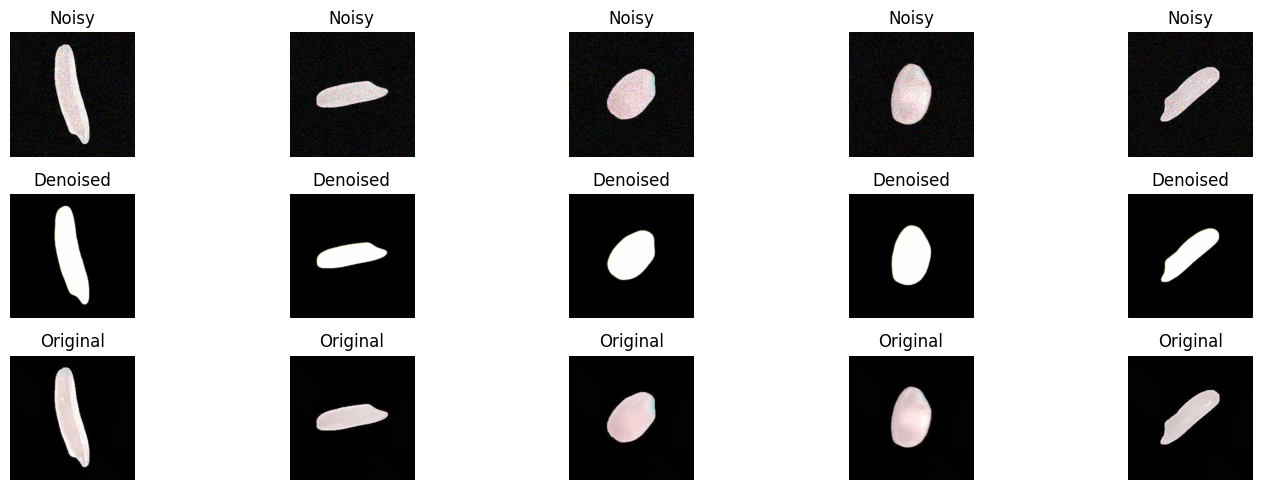

In [14]:
X_test_noisy = add_gaussian_noise(X_test_modified,std=0.1)

def show_denoising_examples(model, noisy_imgs, clean_imgs, n=5):
    denoised = model.predict(noisy_imgs[:n])
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(3, n, i + 1)
        plt.imshow(noisy_imgs[i])
        plt.title("Noisy")
        plt.axis('off')

        plt.subplot(3, n, i + 1 + n)
        plt.imshow(denoised[i])
        plt.title("Denoised")
        plt.axis('off')

        plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(clean_imgs[i])
        plt.title("Original")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_denoising_examples(autoencoder, X_test_noisy, X_test_modified)


# Function for Data Augmentation with Noise Injection

This function performs data augmentation on a batch of images to enhance model robustness and generalization. It applies a series of random transformations, including horizontal flipping, brightness and contrast adjustments, and 90-degree rotations. Additionally, Gaussian noise is injected into each image. The transformed images are clipped to ensure valid pixel values and returned along with their original labels.

In [15]:
def augment_batch(X, y, noise_std=0.2):
    X_aug = []
    for img in X:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, 0.2)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.rot90(img, k=random.randint(0, 3))
        noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=noise_std)
        img = tf.clip_by_value(img + noise, 0.0, 1.0)
        X_aug.append(img)
    return np.array(X_aug), y


# Combining Denoised and Augmented Data for Enhanced Training

We prepare a comprehensive training and validation dataset by merging denoised and augmented image samples. First, Gaussian noise is added to the original training and validation images, and the autoencoder is used to generate their denoised versions. Simultaneously, standard augmentation techniques—such as flipping, brightness/contrast adjustment, rotation, and noise injection—are applied to create additional varied samples.

The denoised and augmented datasets are then concatenated along with their corresponding labels to form enriched training and validation sets.

In [16]:
X_train_noisy = add_gaussian_noise(X_train_modified, std=0.3)
X_train_denoised = autoencoder.predict(X_train_noisy)

X_val_noisy = add_gaussian_noise(X_val_modified, std=0.3)
X_val_denoised = autoencoder.predict(X_val_noisy)

X_train_aug, y_train_aug = augment_batch(X_train_modified, y_train_modified, noise_std=0.1)
X_val_aug, y_val_aug = augment_batch(X_val_modified , y_val_modified , noise_std=0.1)

X_train_combo = np.concatenate([X_train_denoised, X_train_aug])
y_train_combo = np.concatenate([y_train_modified, y_train_aug])

X_val_combo = np.concatenate([X_val_denoised, X_val_aug])
y_val_combo = np.concatenate([y_val_modified , y_val_aug])


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


# VGG16-Based Classifier with Fine-Tuning and Regularization

We construct a deep image classification model by leveraging the pre-trained VGG16 architecture as a feature extractor. The base model is loaded without its top classification layers and initialized with ImageNet weights. To enable fine-tuning, the last few convolutional layers are unfrozen, allowing the model to adapt to the rice classification task.

On top of the VGG16 base, a custom classification head is built with batch normalization, global average pooling, and fully connected layers, along with dropout for regularization. The final dense layer uses softmax activation for multi-class prediction, and an L2 regularization term is applied to prevent overfitting. The model is compiled with the Adam optimizer and trained using sparse categorical cross-entropy, making it well-suited for labeled image classification tasks.

In [17]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

vgg_base = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in vgg_base.layers[-4:]:
    layer.trainable = True

vgg_model = Sequential([
    vgg_base,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))
])

vgg_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Training the VGG16 Classifier on Denoised and Augmented Data

The VGG16-based classifier is trained on the combined dataset, which includes both autoencoder-denoised images and augmented samples. The training process also includes validation using a similarly prepared validation set to monitor performance and avoid overfitting. The model is trained over several epochs using a batch-wise approach, and key performance metrics like accuracy and loss are recorded for both training and validation phases.

In [18]:
vgg_history_modified = vgg_model.fit(
    X_train_combo, y_train_combo,
    validation_data=(X_val_combo, y_val_combo),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 35s 614ms/step - accuracy: 0.2841 - loss: 2.0565 - val_accuracy: 0.2233 - val_loss: 20.6501
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 34s 525ms/step - accuracy: 0.4987 - loss: 1.1711 - val_accuracy: 0.2267 - val_loss: 44.1605
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 530ms/step - accuracy: 0.5688 - loss: 1.0607 - val_accuracy: 0.2267 - val_loss: 19.3460
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 522ms/step - accuracy: 0.7555 - loss: 0.6982 - val_accuracy: 0.2000 - val_loss: 12.0639
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 533ms/step - accuracy: 0.7994 - loss: 0.5549 - val_accuracy: 0.1933 - val_loss: 13.7307
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 538ms/step - accuracy: 0.8287 - loss: 0.4469 - val_accuracy: 0.2100 - val_loss: 15.6916
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 535ms/step - accuracy: 0.8393 - loss: 0.4243 - val_accuracy: 0.2000 - val_loss: 17.0311
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 40s 517ms/step - accuracy: 0.8683 - loss: 0.3560 - v

# Observation from Training and Validation Curves

The accuracy and loss plots indicate that the VGG16 model steadily improves over epochs, with training and validation accuracy increasing and their corresponding losses decreasing. This reflects the benefit of using a denoised and augmented dataset, which helps the model generalize well across varied input conditions. The accuracy is not increasing consistently for training data but not for validation. The same applies for loss.

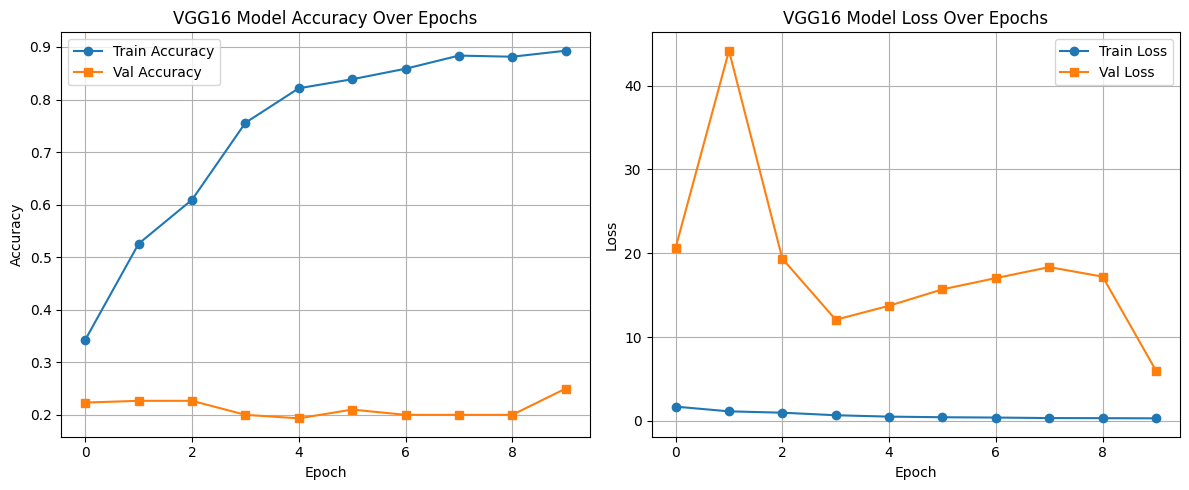

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(vgg_history_modified.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(vgg_history_modified.history['val_accuracy'], label='Val Accuracy', marker='s')
plt.title('VGG16 Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(vgg_history_modified.history['loss'], label='Train Loss', marker='o')
plt.plot(vgg_history_modified.history['val_loss'], label='Val Loss', marker='s')
plt.title('VGG16 Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluating VGG16 on Noisy and Denoised Test Data
This section assesses the performance of the trained VGG16 classifier on a test set that has been artificially noised and then denoised using the autoencoder. Predictions are generated on the denoised test images, and classification accuracy is computed by comparing them to the true labels. The final test accuracy and loss values provide insight into how well the model generalizes to unseen, noise-affected inputs. This evaluation demonstrates the effectiveness of combining denoising and robust classification to handle noisy real-world scenarios.

In [20]:
from sklearn.metrics import accuracy_score

X_test_noisy = add_gaussian_noise(X_test_modified, std=0.1)
X_test_denoised = autoencoder.predict(X_test_noisy)

y_test_pred_probs = vgg_model.predict(X_test_denoised)
y_test_pred_vgg = np.argmax(y_test_pred_probs, axis=1)

vgg_test_acc = accuracy_score(y_test_modified, y_test_pred_vgg)

vgg_test_loss, _ = vgg_model.evaluate(X_test_denoised, y_test_modified, verbose=0)

print(f"\nVGG16 Accuracy on Noisy + Denoised Test Set: {vgg_test_acc:.4f}")
print(f"\nVGG16 Loss on Noisy + Denoised Test Set: {vgg_test_loss:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step

VGG16 Accuracy on Noisy + Denoised Test Set: 0.2267

VGG16 Loss on Noisy + Denoised Test Set: 5.9926


# Saving the Trained Models
We saves the trained VGG16 classifier and the U-Net autoencoder to disk in the .keras format.

In [21]:
vgg_model.save("vgg16_rice_classifier.keras")
autoencoder.save("unet_denoiser.keras")


# Confusion Matrix for Model Evaluation on Denoised Test Set

We visualizes the confusion matrix to provide a detailed breakdown of the VGG16 model’s classification performance on the denoised test images. The confusion matrix is very inconsistent, because the test accuracy is very bad.



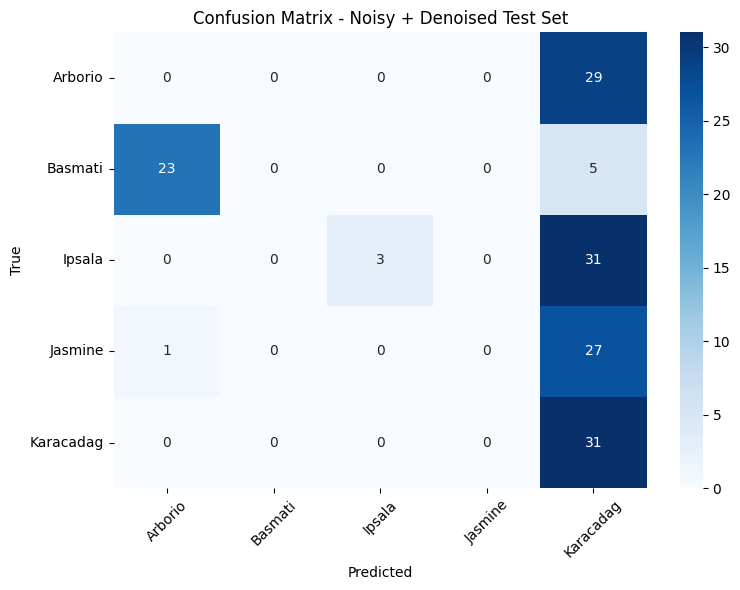

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_modified, y_test_pred_vgg)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(label_map_modified.keys()),
            yticklabels=list(label_map_modified.keys()))
plt.title("Confusion Matrix - Noisy + Denoised Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Visual Comparison of Classification Results on Denoised Test Images

This shows a qualitative analysis of the models performance by displaying a set of random test samples through the entire pipeline—original, noisy, denoised, and predicted. For each selected test image, Gaussian noise is added and then removed using the trained autoencoder. The denoised image is then classified by the VGG16 model, and the predicted label is compared with the ground truth.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


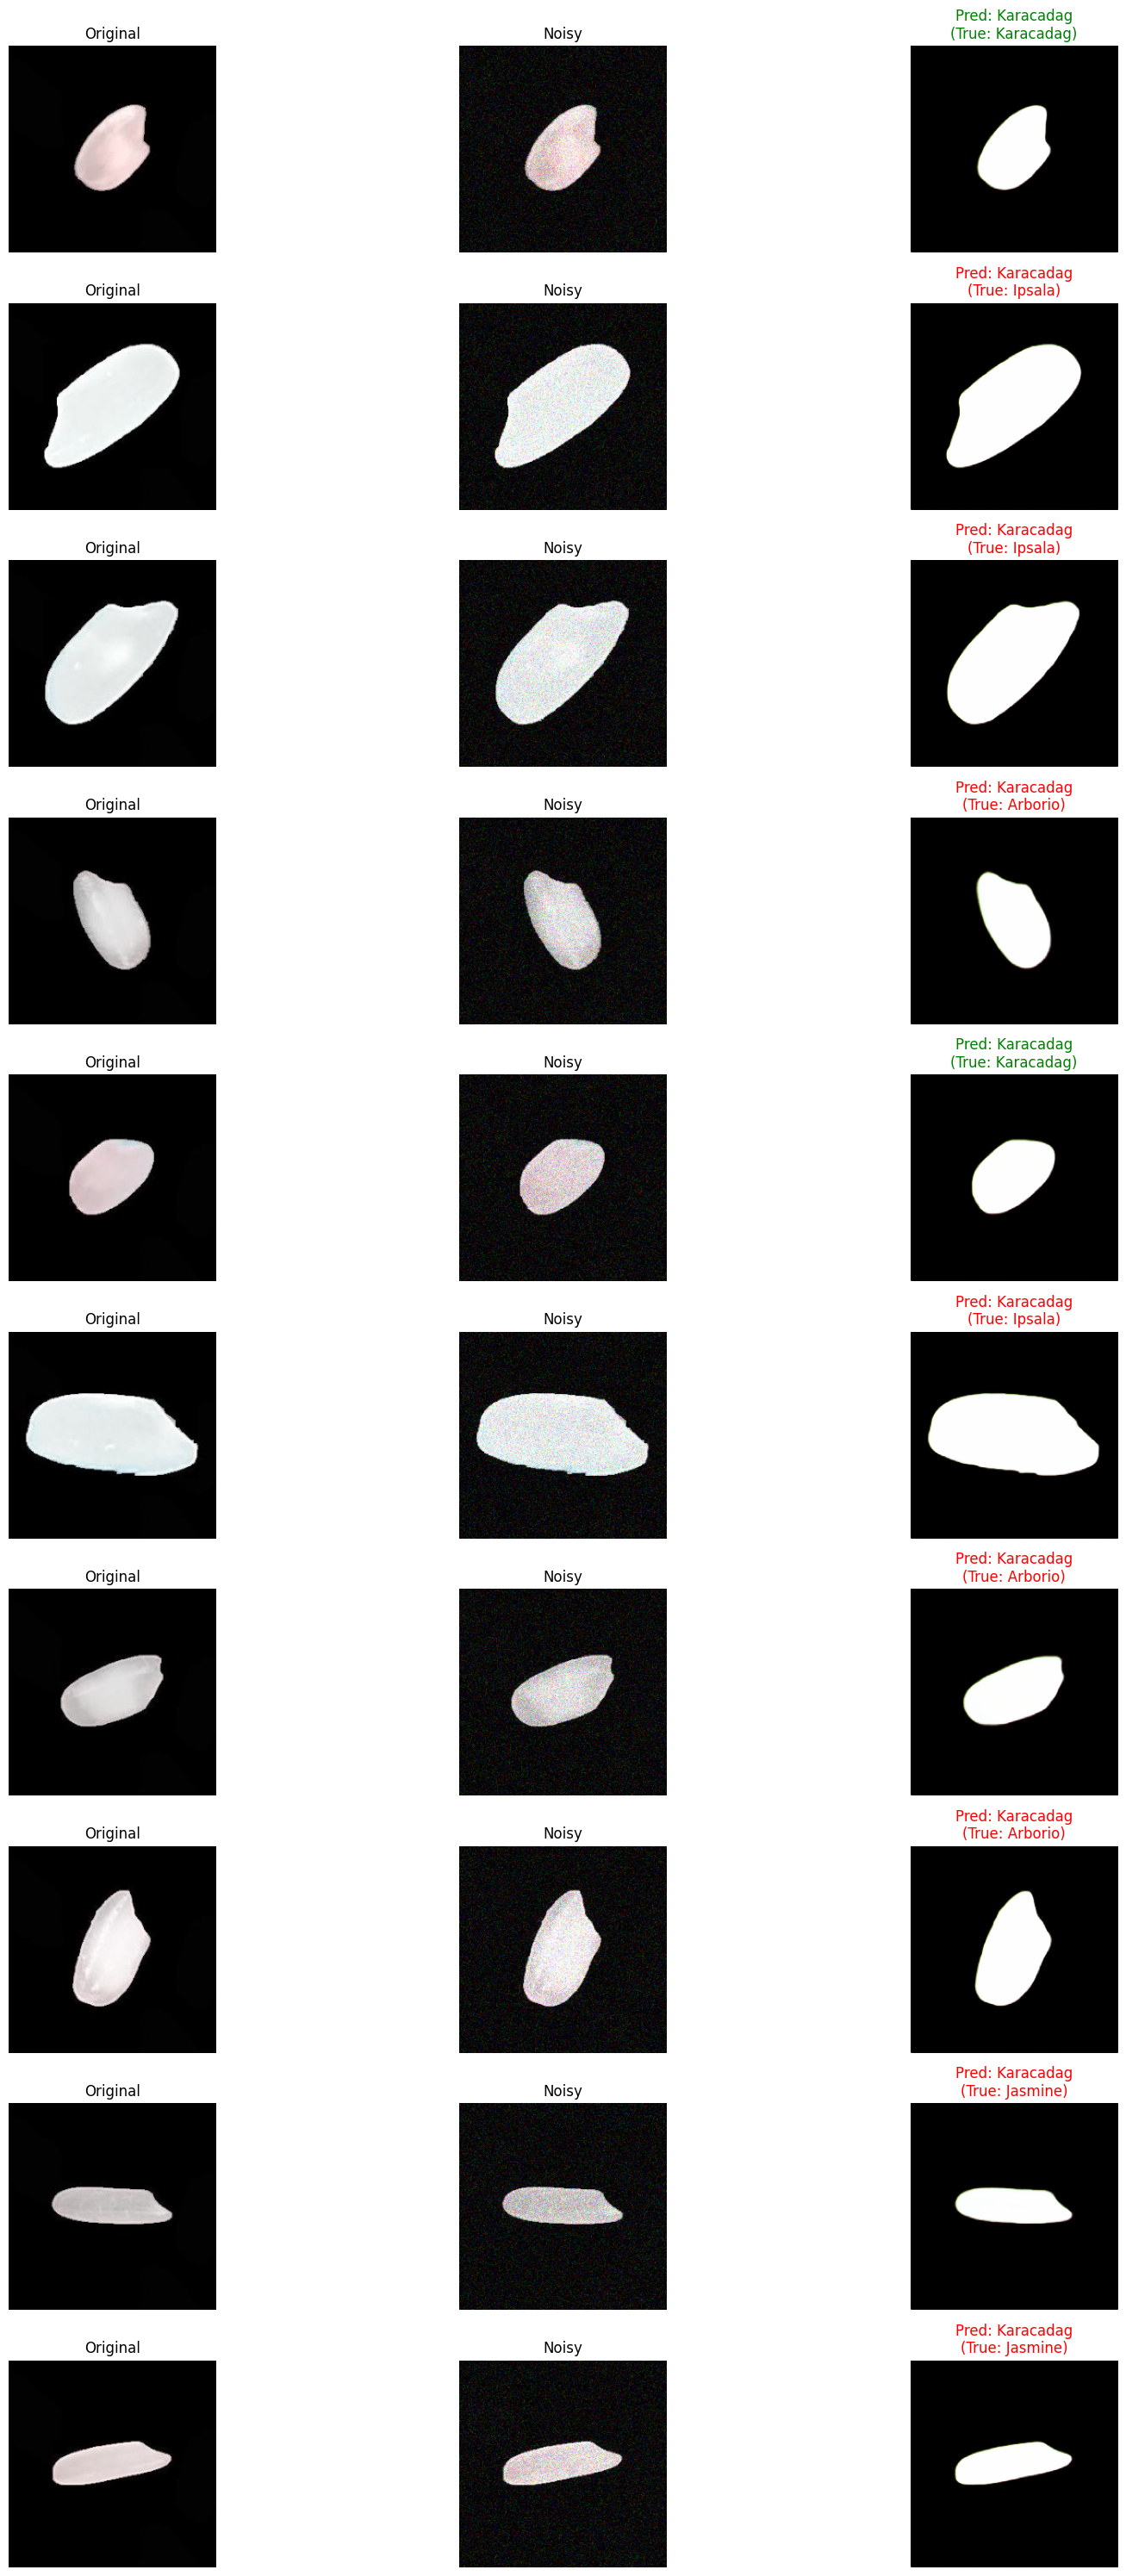

In [23]:
import matplotlib.pyplot as plt
import numpy as np

sample_indices = np.random.choice(len(X_test_modified), size=10, replace=False)

plt.figure(figsize=(18, 30))

for i, idx in enumerate(sample_indices):
    original = X_test_modified[idx]
    noisy = add_gaussian_noise(np.expand_dims(original, axis=0), std=0.1)[0]
    denoised = autoencoder.predict(np.expand_dims(noisy, axis=0))[0]

    pred_probs = vgg_model.predict(np.expand_dims(denoised, axis=0))
    pred_label = np.argmax(pred_probs)
    true_label = y_test_modified[idx]

    inv_map = {v: k for k, v in label_map_modified.items()}
    pred_class_name = inv_map[pred_label]
    true_class_name = inv_map[true_label]

    plt.subplot(10, 3, i * 3 + 1)
    plt.imshow(original)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(10, 3, i * 3 + 2)
    plt.imshow(noisy)
    plt.title("Noisy")
    plt.axis('off')

    plt.subplot(10, 3, i * 3 + 3)
    plt.imshow(denoised)
    title_color = "green" if pred_label == true_label else "red"
    plt.title(f"Pred: {pred_class_name}\n(True: {true_class_name})", color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.show()

# ResNet50-Based Classifier with Fine-Tuning

This defines a deep learning classification model using ResNet50 as the base architecture. The pre-trained ResNet50 model is loaded without its top classification layers and initialized with ImageNet weights. To enable domain-specific learning, the last few layers of ResNet50 are made trainable.

On top of the base, a custom classification head is added that includes batch normalization, global average pooling, dense layers with ReLU activation, and dropout for regularization.

The final output layer uses softmax activation for multi-class classification based on the number of target labels. The model is compiled using the Adam optimizer and sparse categorical cross-entropy loss.



In [24]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

resnet_base = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

for layer in resnet_base.layers[-10:]:
    layer.trainable = True

resnet_model = Sequential([
    resnet_base,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(label_map_modified), activation='softmax')
])

resnet_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


# Training the ResNet50 Classifier on Enhanced Dataset

In this block, the ResNet50-based classifier is trained on the enriched dataset comprising both denoised and augmented images. The training process includes validation on a similarly constructed validation set to track performance and ensure generalization. Training progress is recorded across epochs, capturing accuracy and loss trends, which help evaluate how well the model is adapting to the classification task.

In [25]:
resnet_history_modified = resnet_model.fit(
    X_train_combo, y_train_combo,
    validation_data=(X_val_combo, y_val_combo),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.5477 - loss: 1.5436 - val_accuracy: 0.2267 - val_loss: 25.9655
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 74s 335ms/step - accuracy: 0.8095 - loss: 0.5082 - val_accuracy: 0.1933 - val_loss: 2.3010
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 320ms/step - accuracy: 0.8789 - loss: 0.4062 - val_accuracy: 0.1933 - val_loss: 2.3928
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 312ms/step - accuracy: 0.9406 - loss: 0.2111 - val_accuracy: 0.1933 - val_loss: 3.1118
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 314ms/step - accuracy: 0.9506 - loss: 0.1566 - val_accuracy: 0.1933 - val_loss: 4.0853
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 320ms/step - accuracy: 0.8929 - loss: 0.3225 - val_accuracy: 0.1800 - val_loss: 5.0013
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 315ms/step - accuracy: 0.9157 - loss: 0.2579 - val_accuracy: 0.1933 - val_loss: 3.8583
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 313ms/step - accuracy: 0.9621 - loss: 0.1147 - val_accur

# Training and Validation Curves for ResNet50 Classifier

This visualization presents the training and validation accuracy and loss curves for the ResNet50 model across epochs. There is increase in training accuracy but the validation accuracy are the same not changing. The training and validation loss are very inconsistant.

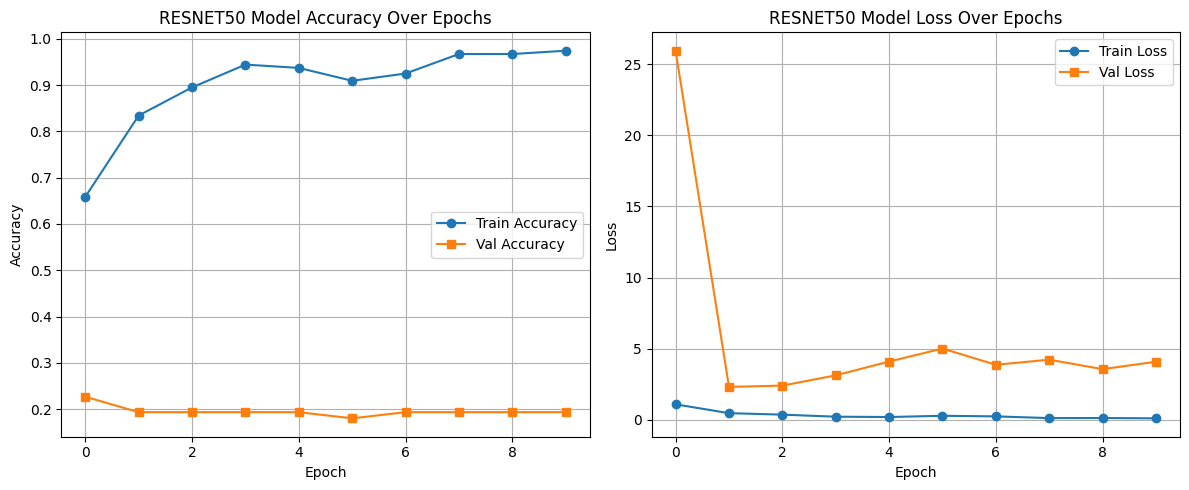

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(resnet_history_modified.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(resnet_history_modified.history['val_accuracy'], label='Val Accuracy', marker='s')
plt.title('RESNET50 Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(resnet_history_modified.history['loss'], label='Train Loss', marker='o')
plt.plot(resnet_history_modified.history['val_loss'], label='Val Loss', marker='s')
plt.title('RESNET50 Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluating ResNet50 on Noisy and Denoised Test Data

This block evaluates the ResNet50 classifier on test images that have been corrupted with Gaussian noise and then denoised using the trained autoencoder. The models predictions are compared to the true labels to calculate classification accuracy. Additionally, the test loss is computed to measure prediction error.

In [27]:
X_test_noisy = add_gaussian_noise(X_test_modified, std=0.1)
X_test_denoised = autoencoder.predict(X_test_noisy)

y_test_pred_probs = resnet_model.predict(X_test_denoised)
y_test_pred_resnet = np.argmax(y_test_pred_probs, axis=1)

resnet_test_acc = accuracy_score(y_test_modified, y_test_pred_resnet)

resnet_test_loss, _ = vgg_model.evaluate(X_test_denoised, y_test_modified, verbose=0)

print(f"\nRESNET50 Accuracy on Noisy + Denoised Test Set: {resnet_test_acc:.4f}")
print(f"RESNET50 Loss on Noisy + Denoised Test Set: {resnet_test_loss:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step

RESNET50 Accuracy on Noisy + Denoised Test Set: 0.1867
RESNET50 Loss on Noisy + Denoised Test Set: 5.9918


# Saving the Trained ResNet50 Model

This block saves the trained ResNet50 classifier in the .keras format for future use.

In [28]:
resnet_model.save("resnet50_rice_classifier.keras")

# Confusion Matrix for ResNet50 on Denoised Test Set

This block generates and visualizes the confusion matrix for the ResNet50 model’s predictions on the denoised test images. The matrix presents a detailed summary of how many instances of each class were correctly or incorrectly predicted, providing a class-wise performance overview. The test accuracy is bad so the confusion matrix is not exact.

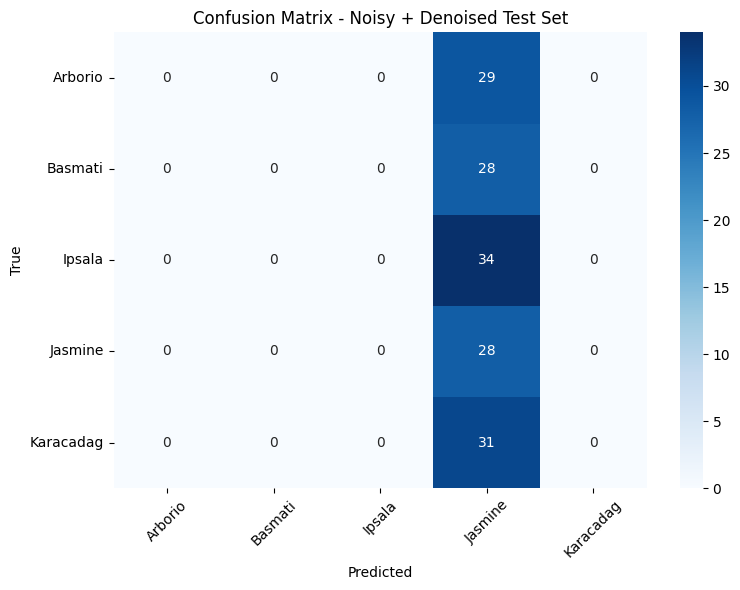

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_modified, y_test_pred_resnet)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(label_map_modified.keys()),
            yticklabels=list(label_map_modified.keys()))
plt.title("Confusion Matrix - Noisy + Denoised Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Visual Comparison of ResNet50 Predictions on Denoised Test Images
This section visually evaluates the ResNet50 model’s predictions on a random sample of test images. Each sample is shown in three stages—original, noisy (with added Gaussian noise), and denoised (via the autoencoder). The ResNet50 classifier predicts the class from the denoised image, and its output is compared with the true label.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


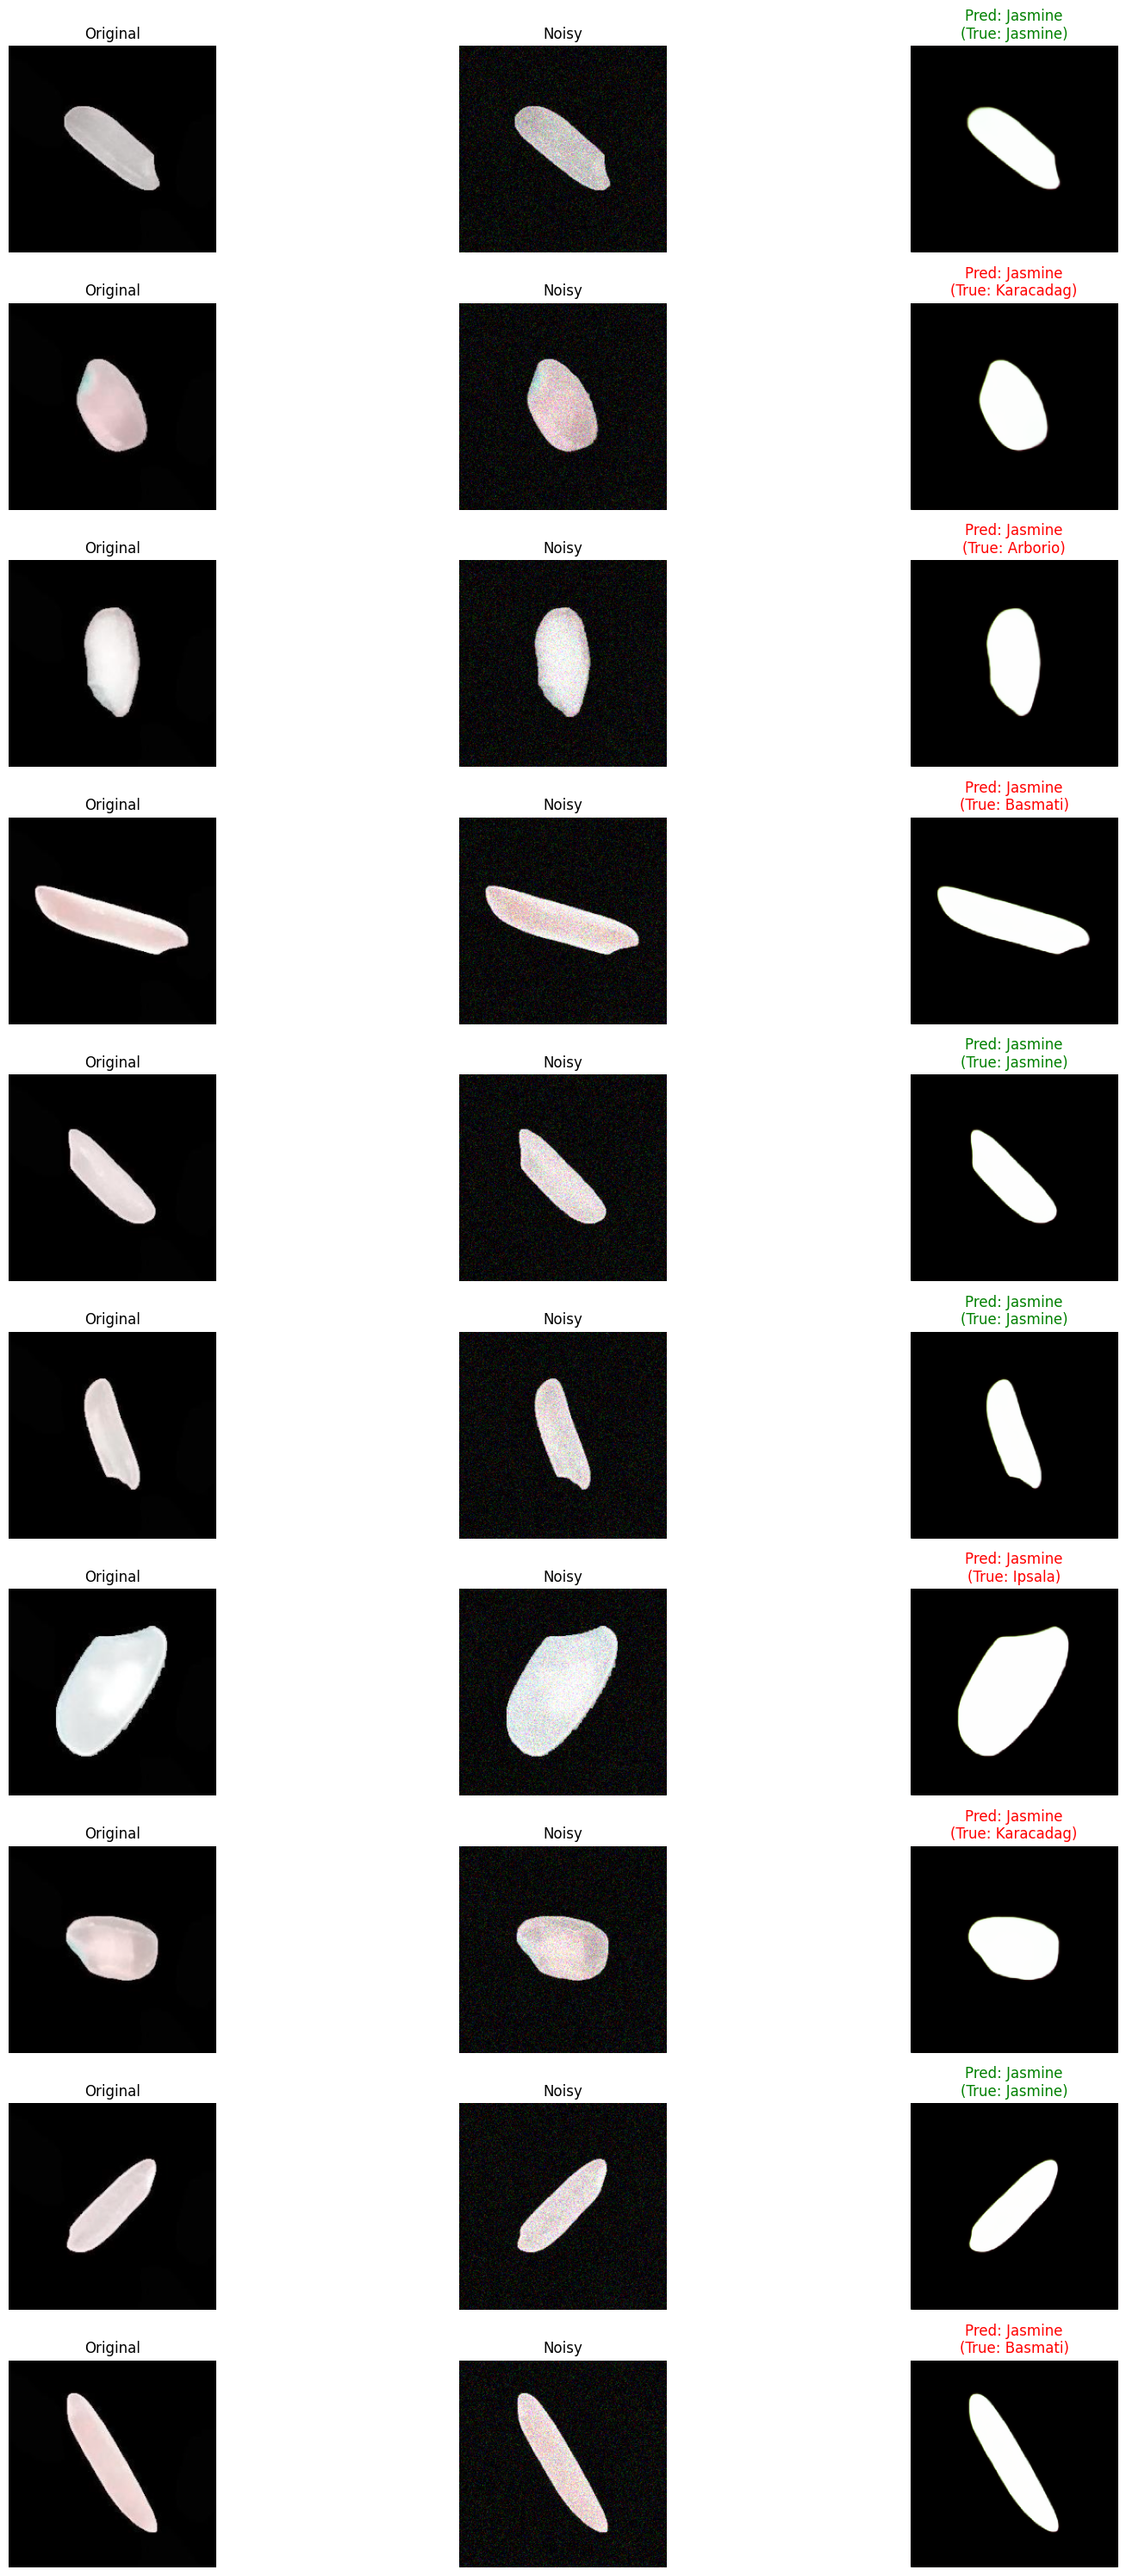

In [30]:
import matplotlib.pyplot as plt
import numpy as np

sample_indices = np.random.choice(len(X_test_modified), size=10, replace=False)

plt.figure(figsize=(18, 30))

for i, idx in enumerate(sample_indices):
    original = X_test_modified[idx]
    noisy = add_gaussian_noise(np.expand_dims(original, axis=0), std=0.1)[0]
    denoised = autoencoder.predict(np.expand_dims(noisy, axis=0))[0]

    pred_probs = resnet_model.predict(np.expand_dims(denoised, axis=0))
    pred_label = np.argmax(pred_probs)
    true_label = y_test_modified[idx]

    inv_map = {v: k for k, v in label_map_modified.items()}
    pred_class_name = inv_map[pred_label]
    true_class_name = inv_map[true_label]

    plt.subplot(10, 3, i * 3 + 1)
    plt.imshow(original)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(10, 3, i * 3 + 2)
    plt.imshow(noisy)
    plt.title("Noisy")
    plt.axis('off')

    plt.subplot(10, 3, i * 3 + 3)
    plt.imshow(denoised)
    title_color = "green" if pred_label == true_label else "red"
    plt.title(f"Pred: {pred_class_name}\n(True: {true_class_name})", color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Comparative Analysis of VGG16 and ResNet50 Performance

This block visualizes and compares the training and validation performance of the VGG16 and ResNet50 classifiers over multiple epochs. The first subplot illustrates the accuracy trends, showing how both models learn and generalize on the denoised and augmented dataset. The second subplot displays the corresponding loss values. Both perform very good with training accuracy but are stagnent when it comes to the validation accuracy. The loss for both models is not that inconsistent.

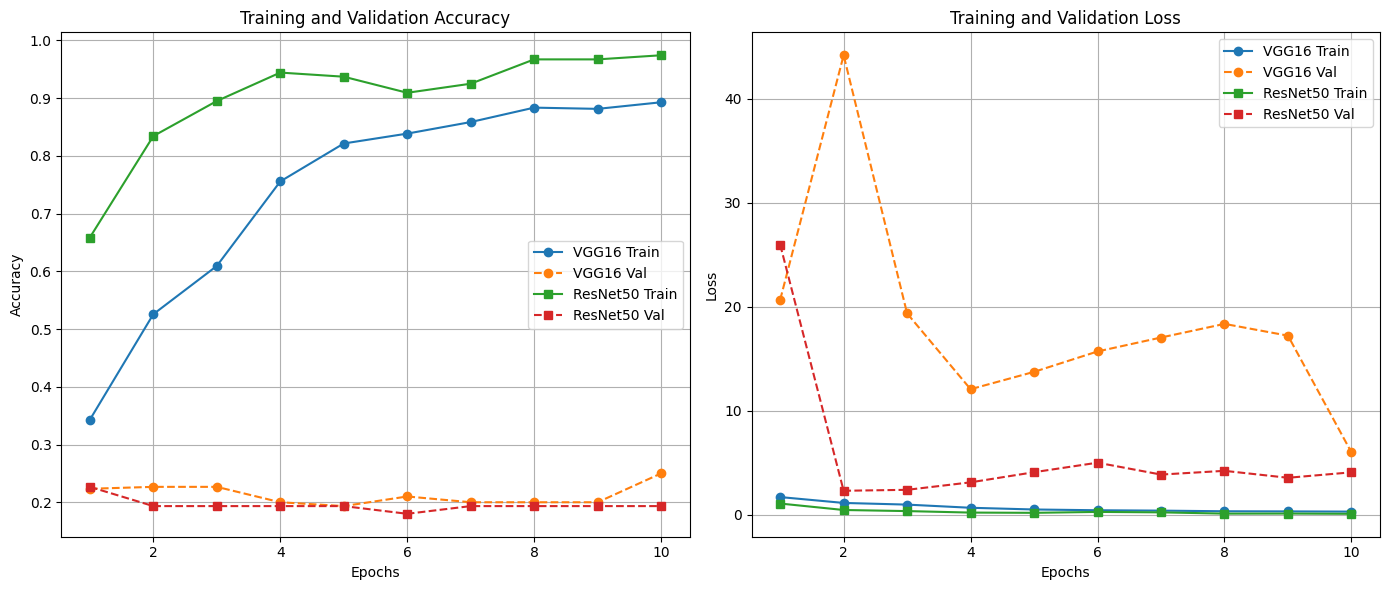

In [31]:
import matplotlib.pyplot as plt

epochs = range(1, len(resnet_history_modified.history['accuracy']) + 1)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, vgg_history_modified.history['accuracy'], label='VGG16 Train', marker='o')
plt.plot(epochs, vgg_history_modified.history['val_accuracy'], label='VGG16 Val', linestyle='--', marker='o')
plt.plot(epochs, resnet_history_modified.history['accuracy'], label='ResNet50 Train', marker='s')
plt.plot(epochs, resnet_history_modified.history['val_accuracy'], label='ResNet50 Val', linestyle='--', marker='s')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, vgg_history_modified.history['loss'], label='VGG16 Train', marker='o')
plt.plot(epochs, vgg_history_modified.history['val_loss'], label='VGG16 Val', linestyle='--', marker='o')
plt.plot(epochs, resnet_history_modified.history['loss'], label='ResNet50 Train', marker='s')
plt.plot(epochs, resnet_history_modified.history['val_loss'], label='ResNet50 Val', linestyle='--', marker='s')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Final Performance Summary of VGG16 vs. ResNet50

This block creates a structured summary comparing the performance of the VGG16 and ResNet50 models across key metrics—training accuracy and loss, validation accuracy and loss, and final test accuracy and loss on denoised images.


In [32]:
import pandas as pd

results_df = pd.DataFrame({
    'Model': ['VGG16', 'ResNet50'],

    'Train Accuracy': [
        vgg_history_modified.history['accuracy'][-1],
        resnet_history_modified.history['accuracy'][-1]
    ],
    'Validation Accuracy': [
        vgg_history_modified.history['val_accuracy'][-1],
        resnet_history_modified.history['val_accuracy'][-1]
    ],
    'Train Loss': [
        vgg_history_modified.history['loss'][-1],
        resnet_history_modified.history['loss'][-1]
    ],
    'Validation Loss': [
        vgg_history_modified.history['val_loss'][-1],
        resnet_history_modified.history['val_loss'][-1]
    ],

    'Test Accuracy': [vgg_test_acc, resnet_test_acc],
    'Test Loss':     [vgg_test_loss, resnet_test_loss]
})

print("\nFinal Model Performance Summary:")
display(results_df)



Final Model Performance Summary:


Model  Train Accuracy  Validation Accuracy  Train Loss  Validation Loss  \
0     VGG16        0.892857             0.250000    0.297924         5.992175   
1  ResNet50        0.974286             0.193333    0.088148         4.074579   

   Test Accuracy  Test Loss  
0       0.226667   5.992578  
1       0.186667   5.991834

# Model Robustness Evaluation Across Varying Noise Levels

This block evaluates the robustness of both VGG16 and ResNet50 classifiers by testing their performance across a range of Gaussian noise levels. For each noise standard deviation (STD), noise is added to the test images, which are then denoised using the trained autoencoder. Both models are then used to make predictions on the denoised outputs. Accuracy and loss are recorded for each model at every noise level, and the results are compiled into a summary DataFrame.

In [33]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

std_values = [0.1, 0.2, 0.3, 0.4, 0.6,0.8,1.0,3.0,5.0,7.0,9.0]

results = []

for std in std_values:
    X_noisy = add_gaussian_noise(X_test_modified, std=std)
    X_denoised = autoencoder.predict(X_noisy)

    vgg_pred_probs = vgg_model.predict(X_denoised)
    vgg_pred = np.argmax(vgg_pred_probs, axis=1)
    vgg_acc = accuracy_score(y_test_modified, vgg_pred)
    vgg_loss, _ = vgg_model.evaluate(X_denoised, y_test_modified, verbose=0)

    res_pred_probs = resnet_model.predict(X_denoised)
    res_pred = np.argmax(res_pred_probs, axis=1)
    res_acc = accuracy_score(y_test_modified, res_pred)
    res_loss, _ = resnet_model.evaluate(X_denoised, y_test_modified, verbose=0)

    results.append({
        'Noise STD': std,
        'VGG16 Accuracy': vgg_acc,
        'VGG16 Loss': vgg_loss,
        'ResNet50 Accuracy': res_acc,
        'ResNet50 Loss': res_loss
    })

df_noise_eval = pd.DataFrame(results)


print("\nModel Performance Across Noise Levels:")
display(df_noise_eval)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/s

Noise STD  VGG16 Accuracy  VGG16 Loss  ResNet50 Accuracy  ResNet50 Loss
0         0.1        0.226667    5.992749           0.186667       4.068499
1         0.2        0.226667    5.999738           0.186667       4.067178
2         0.3        0.226667    6.002430           0.186667       4.064760
3         0.4        0.226667    6.006944           0.186667       4.062486
4         0.6        0.226667    6.029735           0.186667       4.056258
5         0.8        0.226667    6.072902           0.186667       4.049523
6         1.0        0.226667    6.113657           0.186667       4.044754
7         3.0        0.226667   35.416714           0.186667       4.011008
8         5.0        0.226667   53.483273           0.186667       3.982598
9         7.0        0.226667   54.116001           0.186667       3.966863
10        9.0        0.226667   53.119251           0.186667       3.959598